In [1]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
from PIL import Image

from IPython.display import display

import os

In [7]:
print("[INFO] loading EAST text detector...")
east_network = cv2.dnn.readNet("../models/frozen_east_text_detection.pb")

[INFO] loading EAST text detector...


In [35]:
def detect_text(name):
	image = cv2.imread(f"../datasets/all_ds/SciTSR/train/img/{name}")
	orig = image.copy()

	newW, newH = int(image.shape[1]*1.5), int(image.shape[0]*1.5)
	newW, newH = newW - (newW % 32), newH - (newH % 32)
	rW = image.shape[1] / newW
	rH = image.shape[0] / newH

	image = cv2.resize(image, (newW, newH), cv2.INTER_AREA)

	# prepare input
	blob = cv2.dnn.blobFromImage(image, 1.0, (image.shape[1], image.shape[0]), (100, 100, 100), swapRB=True, crop=False)

	# predict bounding boxes
	start = time.time()
	east_network.setInput(blob)
	scores, geometry = east_network.forward([
		"feature_fusion/Conv_7/Sigmoid",
		"feature_fusion/concat_3"
	])
	end = time.time()

	print("[INFO] text detection took {:.6f} seconds".format(end - start), end="\r")

	numRows, numCols = scores.shape[2:4]
	rects = []
	confidences = []
	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the geometrical
		# data used to derive potential bounding box coordinates that
		# surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability, ignore it
			if scoresData[x] < 0.1:
				continue
			# compute the offset factor as our resulting feature maps will
			# be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			# extract the rotation angle for the prediction and then
			# compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			# use the geometry volume to derive the width and height of
			# the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			# compute both the starting and ending (x, y)-coordinates for
			# the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			# add the bounding box coordinates and probability score to
			# our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	result = orig.copy()
	boxes = non_max_suppression(np.array(rects), probs=confidences)
	# loop over the bounding boxes
	for (startX, startY, endX, endY) in boxes:
		# scale the bounding box coordinates based on the respective
		# ratios
		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)
		# draw the bounding box on the image
		cv2.rectangle(result, (startX, startY), (endX, endY), (0, 255, 0), 2)

	return Image.fromarray(result)

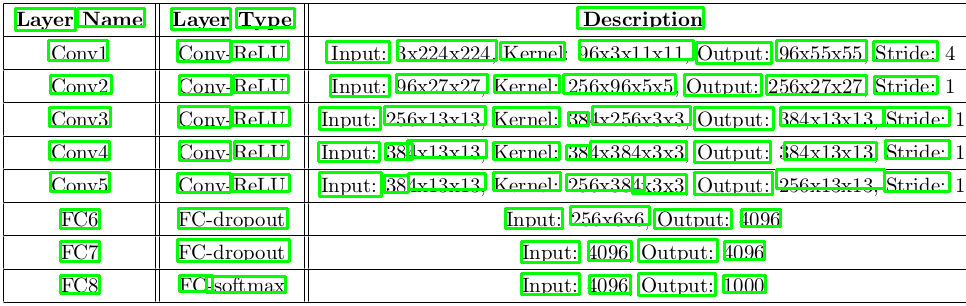

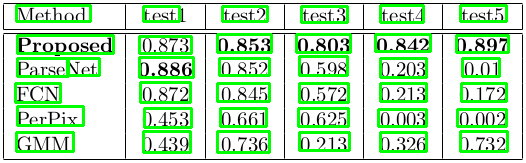

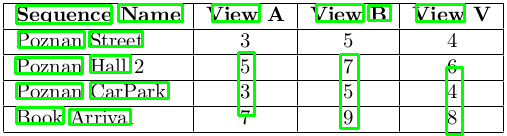

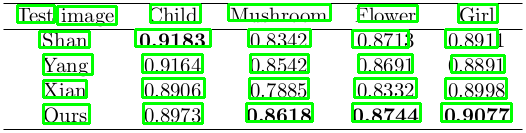

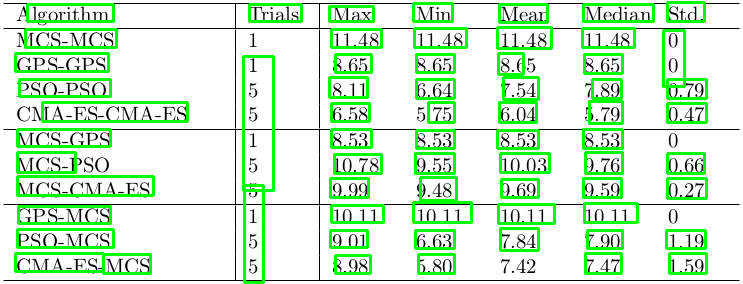

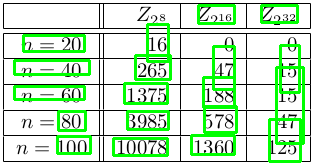

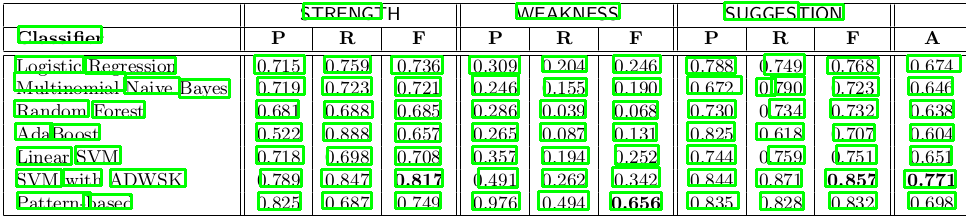

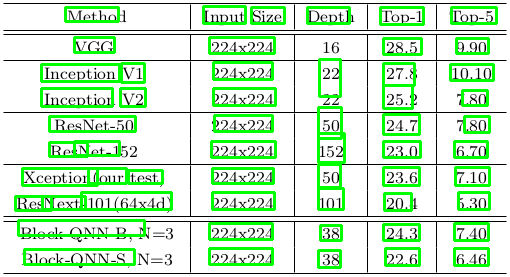

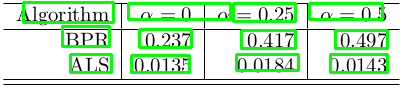

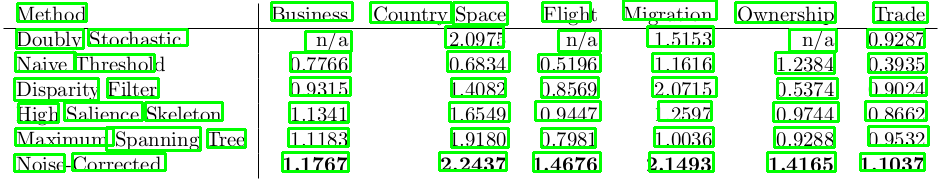

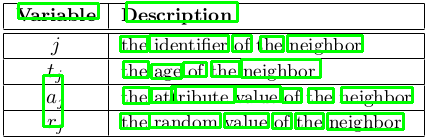

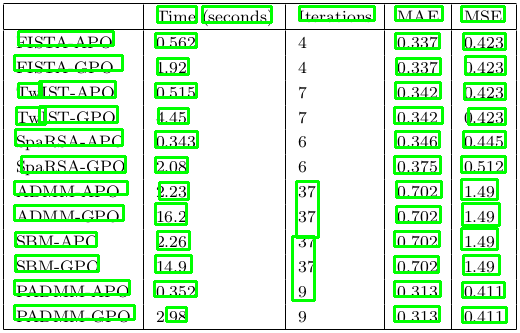

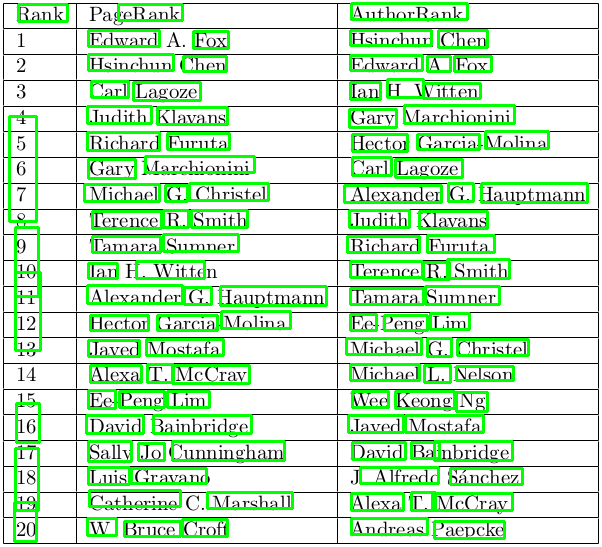

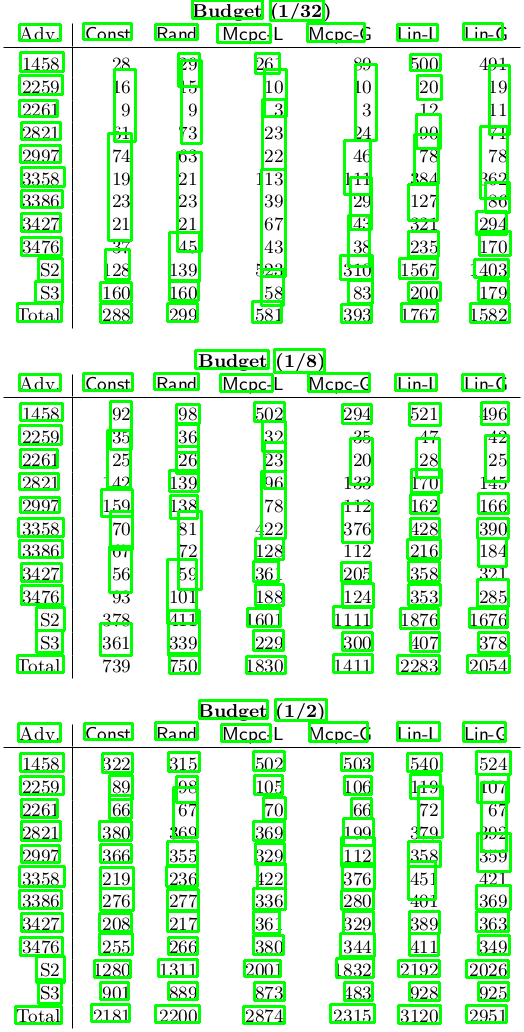

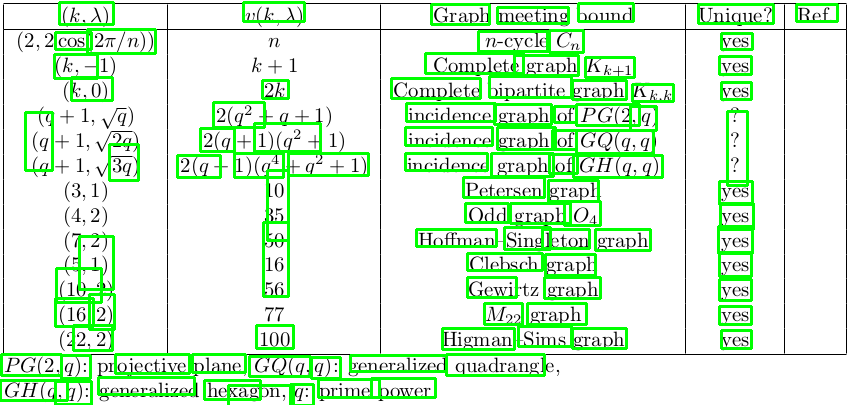

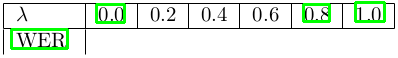

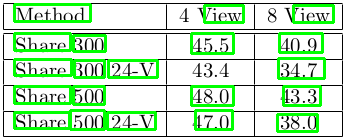

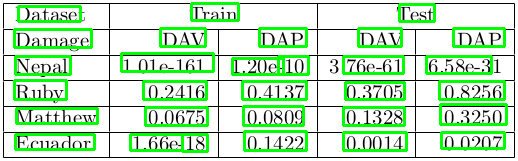

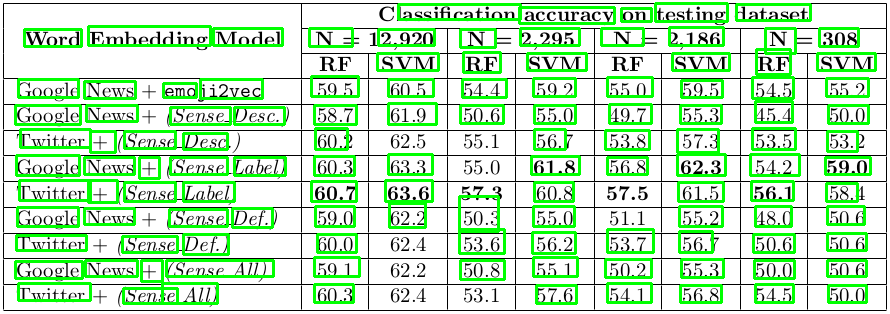

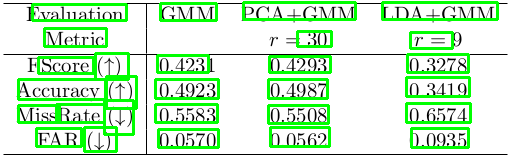

In [36]:
for n in os.listdir("../datasets/all_ds/SciTSR/train/img/")[10:30]:
    display(detect_text(n))

Table line detection.

In [57]:
def extract_lines(name):
    image = cv2.imread(f"../datasets/all_ds/SciTSR/train/img/{name}", cv2.IMREAD_GRAYSCALE)

    kernel_size = 5
    blur_gray = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    low_threshold = 100
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 10 # maximum gap in pixels between connectable line segments
    line_image = np.zeros_like(image)  # creating a blank to draw lines on

    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 1)

    return Image.fromarray(
        cv2.vconcat([
            image,
            line_image
        ])
    )

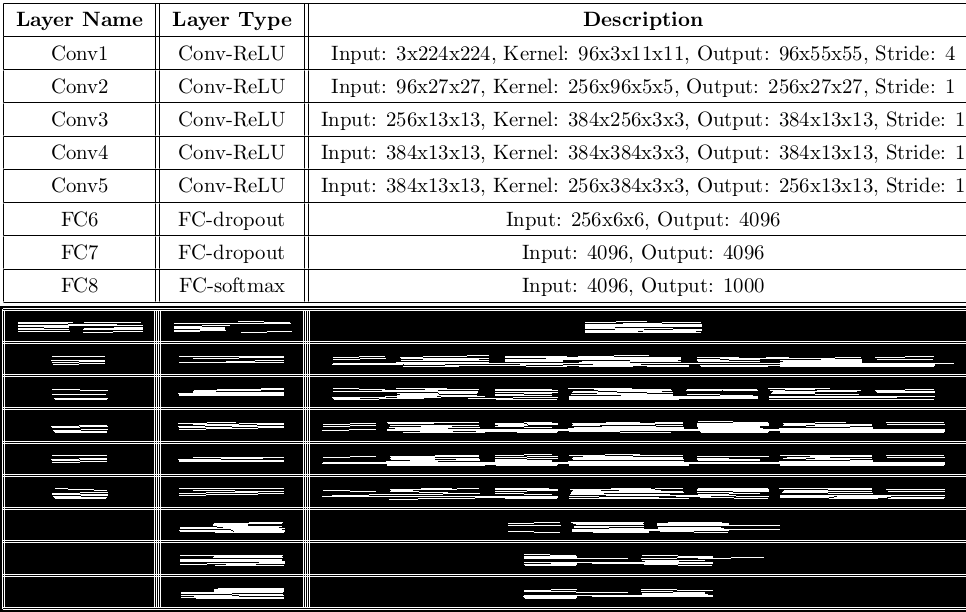

In [58]:
for n in os.listdir("../datasets/all_ds/SciTSR/train/img/")[10:11]:
    display(extract_lines(n))

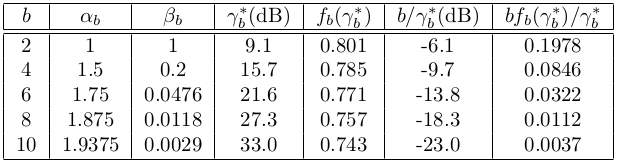

In [272]:
Image.fromarray(image)

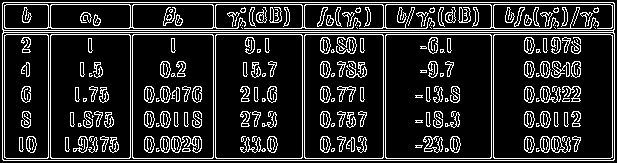

In [273]:
Image.fromarray(edges)

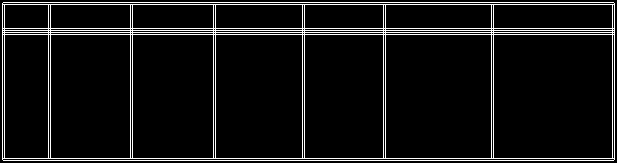

In [274]:
Image.fromarray(line_image)

EAST tensorflow hub model.

In [162]:
import tensorflow as tf

2022-08-05 12:00:54.634424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tigran-analysed/Desktop/analysed.ai/table_extractor/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-05 12:00:54.634487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [163]:
interpreter = tf.lite.Interpreter(model_path="../models/lite-model_east-text-detector_fp16_1.tflite")

In [165]:
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [166]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [177]:
image = cv2.imread("../datasets/all_ds/SciTSR/train/img/0704.3878v1.1.png")
image = cv2.resize(image, (320, 320), interpolation=cv2.INTER_AREA)
image = np.expand_dims(image, 0).astype(np.float32)
image.shape

(1, 320, 320, 3)

In [178]:
interpreter.set_tensor(input_index, image)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)

# test_labels.append(label.numpy()[0])
# test_imgs.append(img)